# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая умеет определять рыночную стоимость автомобиля. Предоставлены данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

In [61]:
!pip install lightgbm
!pip install missingno
!pip install catboost

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error as mse

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

import lightgbm as lgb
from lightgbm import LGBMRegressor

import missingno as msno

## Загрузка данных

In [63]:
try:
    df = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Проект. Численные методы/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [64]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [66]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Предоставлен достаточно большой объем данных, содержащий 354 тысячи записей.\
Также видно, что в данных много пропущенных значений.\
По описательным статистикам можно заметить, что в данных также есть аномальные значения, например, 1000 или 9999 год регистрации. То же самое и со всеми остальными показателями: минимальная цена равная 0, 0 месяц регистрации и т.д.

## Предобработка данных

### Заполнение пропусков

<AxesSubplot:>

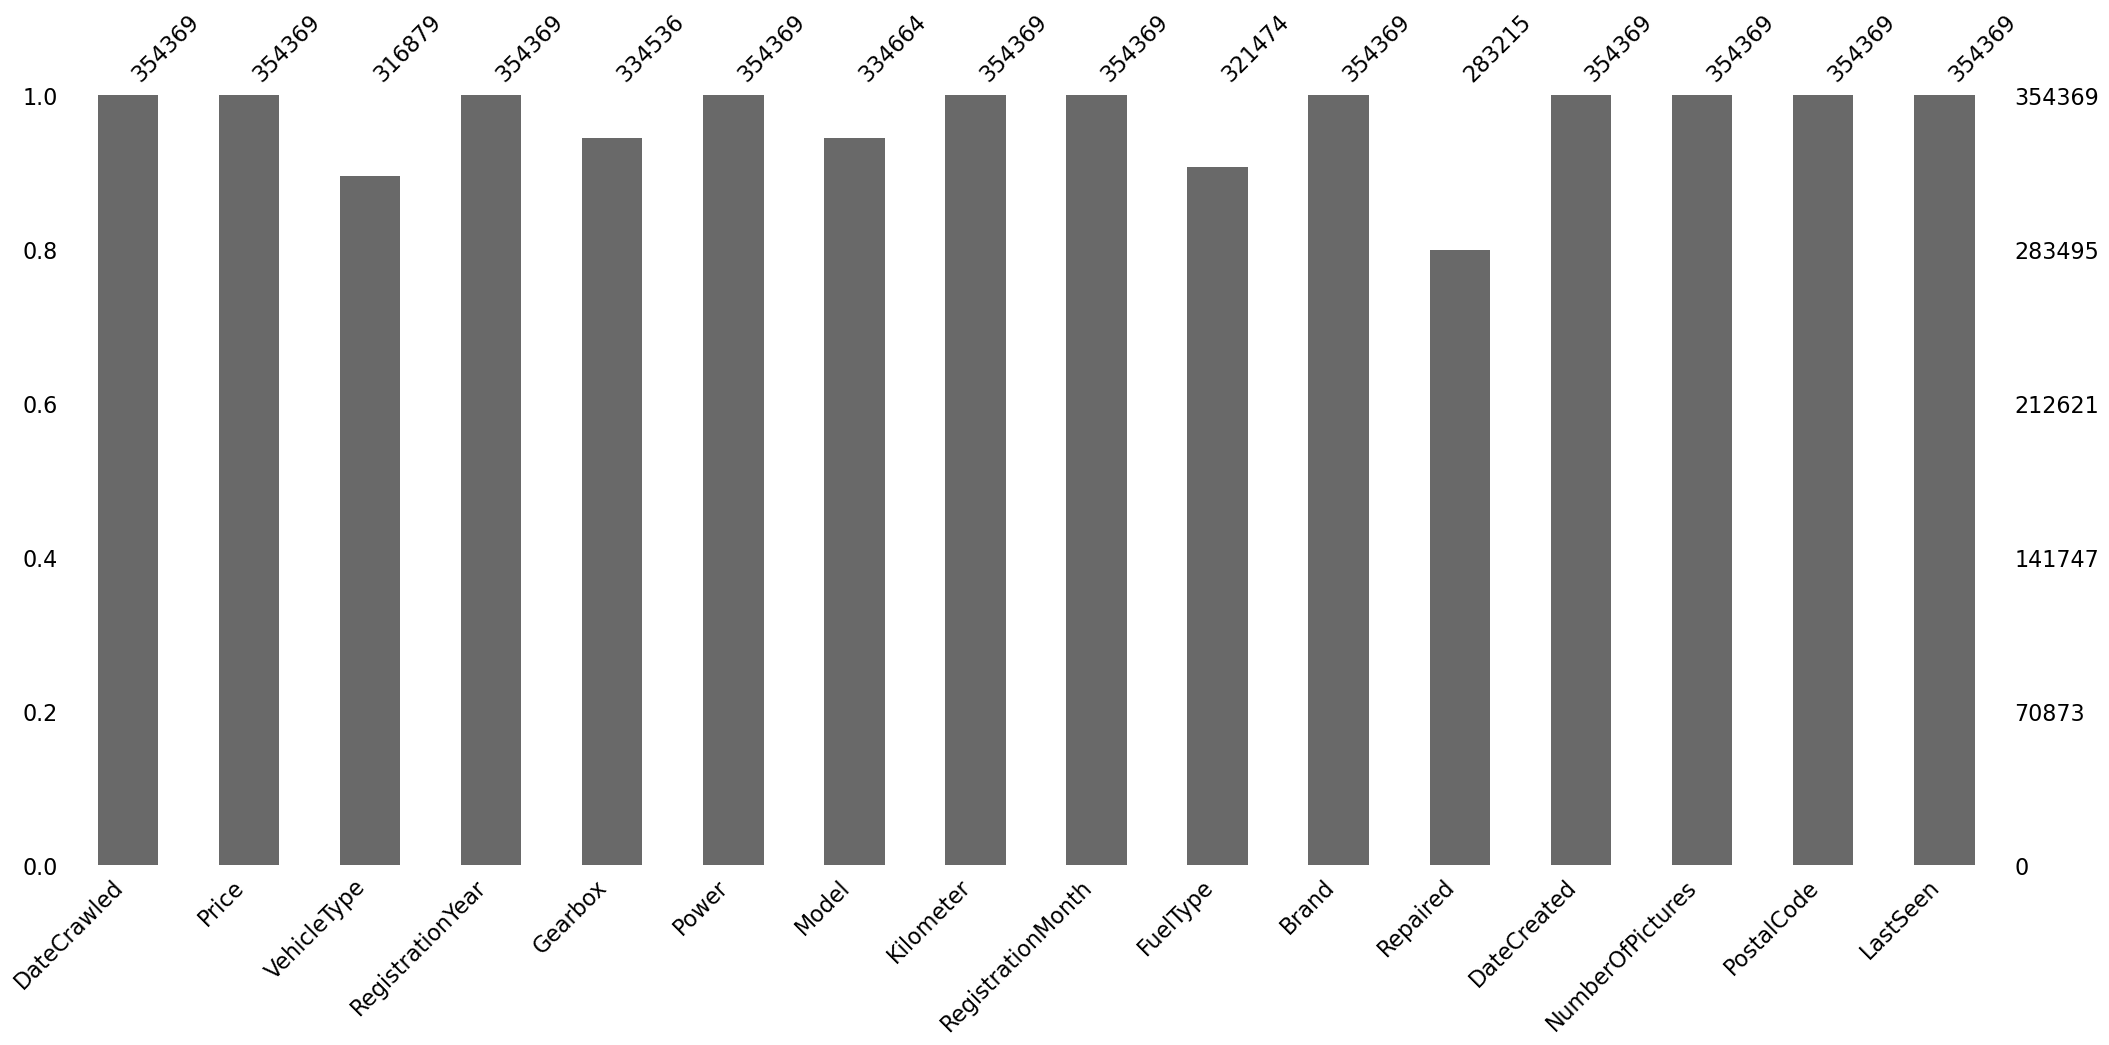

In [67]:
msno.bar(df)

In [68]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [69]:
df.groupby(['VehicleType'])['Price'].count().sort_values(ascending=False)

VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: Price, dtype: int64

In [70]:
df.groupby(['FuelType'])['Price'].count().sort_values(ascending=False)

FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: Price, dtype: int64

В случае с топливом, думаю, можно заполнить все пропущенные значения типом petrol, так как это наиболее частый вид топлива. И если это поле не заполнено, скорее всего все по стандарту, т.е. бензин.

In [71]:
#замена пустых значений в столбце FuelType на petrol
df.loc[df['FuelType'].isna(), 'FuelType'] = 'petrol'

In [72]:
#тоже самое можно сделать с типом коробки передач, т.к. также самая распространенная - механика
df.groupby('Gearbox')['Price'].count().sort_values(ascending=False)

Gearbox
manual    268251
auto       66285
Name: Price, dtype: int64

In [73]:
#замена пустых значений на manual
df.loc[df['Gearbox'].isna(), 'Gearbox'] = 'manual'

Также поступлю и с восстановленными машинами, т.к. скорее всего, если этот параметр не указан, то машина в ремонте не была.

In [74]:
#замена пустых значений на 0
df.loc[df['Repaired'].isna(), 'Repaired'] = 'no'

In [75]:
#заполнение пропусков в Model самыми популярными модели среди каждого бренда машин
for i in df['Brand'].unique():
    if i != 'sonstige_autos':
        df.loc[((df['Model'].isna()) & (df['Brand'] == i)), 'Model'] = df.loc[df['Brand'] == i].groupby('Model')['Price'].count().sort_values(ascending=False).idxmax()
    else:
        df.loc[((df['Model'].isna()) & (df['Brand'] == i)), 'Model'] = 'unknown'

In [76]:
#Так как тип транспортного средства заполнить качественно вряд ли удастся, то решил заполнить их 'unknown'
df.loc[df['VehicleType'].isna(), 'VehicleType'] = 'unknown'

In [77]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Удаление лишних данных

In [78]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

Данные столбец не играет никакой роли для обучения, т.к. в нем одниаковое число. Столбец можно удалить

Также, удалить можно столбцы с датами и с почтовым индексом.

In [79]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth'], axis=1)

In [80]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Обработка аномалий

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>],
       [<AxesSubplot:title={'center':'Power'}>,
        <AxesSubplot:title={'center':'Kilometer'}>]], dtype=object)

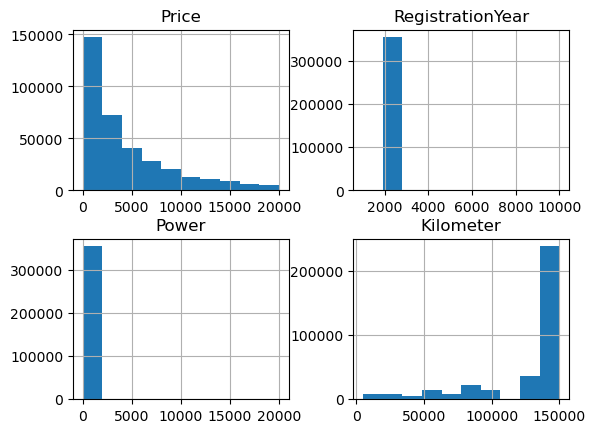

In [81]:
df.hist()

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

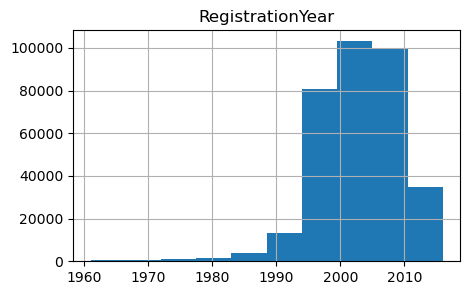

In [82]:
#Удаление аномальных значений для года регистрации, чтобы остались только в диапазоне 1950-2023
df_new = df.query('(1960 < RegistrationYear <= 2016)')
df_new.hist('RegistrationYear', figsize=(5,3))

In [83]:
#Также удаление аномальных значений по лошадиным силам автомобиля
#df_new = df_new.query('40 <= Power < 500')
df_new.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,no
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,manual,0,kangoo,150000,gasoline,renault,no
40,0,unknown,1990,manual,0,corsa,150000,petrol,opel,no
54,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
354338,180,unknown,1995,manual,0,corsa,125000,petrol,opel,no
354346,2600,unknown,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,no
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354364,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Так как данных с нулевыми значениями мощности слишком много (36137), совсем избавляться от них не стоит. Заменил нули на -1

In [84]:
df_new.loc[df_new['Power'] == 0, 'Power'] = -1

In [85]:
df_new = df_new.query('(40 < Power < 500) | (Power == -1)')

In [86]:
df_new = df_new.query('200 < Price < 20000')

In [87]:
len(df_new) / len(df)

0.8998501561931207

In [88]:
df_new.describe()

,Price,RegistrationYear,Power,Kilometer
count,318879.000000,318879.000000,318879.000000,318879.000000
mean,4714.791940,2002.809868,110.248470,128597.289254
std,4525.732286,6.479050,61.685609,36856.702785
min,202.000000,1961.000000,-1.000000,5000.000000
25%,1300.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,105.000000,150000.000000
75%,6800.000000,2007.000000,143.000000,150000.000000
max,19999.000000,2016.000000,490.000000,150000.000000


В итоге, после очистки всех числовых данных от аномалий было удалено ~9.5% от исходных данных

## Подготовка выборок для обучения моделей

In [89]:
features = df_new.drop('Price', axis=1)
target = df_new['Price']

In [90]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,unknown,1993,manual,-1,golf,150000,petrol,volkswagen,no
1,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [91]:
target.head()

0      480
1    18300
2     9800
3     1500
4     3600
Name: Price, dtype: int64

In [92]:
random_state = 12345

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features,
                                                                                        target,
                                                                                        test_size=0.3,
                                                                                        random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test,
                                                                            target_valid_test,
                                                                            test_size=0.5,
                                                                            random_state=random_state)

print(f'Доля обучающей выборки: {round(len(features_train)/len(features) * 100)}%')
print(f'Доля проверочной выборки: {round(len(features_valid)/len(features) * 100)}%')
print(f'Доля тестовой выборки: {round(len(features_test)/len(features) * 100)}%')

Доля обучающей выборки: 70%
Доля проверочной выборки: 15%
Доля тестовой выборки: 15%


## Обучение моделей

##### LightGBM

In [93]:
columns = [['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']]

In [94]:
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

In [97]:
encoder = OrdinalEncoder()
lgbm_train = features_train.copy()
lgbm_valid = features_valid.copy()
lgbm_test = features_test.copy()

for col in columns:
    lgbm_train[col] = encoder.fit_transform(lgbm_train[col])
    lgbm_valid[col] = encoder.transform(lgbm_valid[col])
    lgbm_test[col] = encoder.transform(lgbm_test[col])
    
lgbm = LGBMRegressor(boosting_type='gbdt', random_state=random_state)
params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60, 80, 100],
    'num_leaves': [21, 31, 41, 51, 61],
}

lgbm_grid_search =  GridSearchCV(lgbm,params, cv=cv, scoring='neg_mean_squared_error', verbose=True)

In [98]:
%%time
lgbm_grid_search.fit(lgbm_train, target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 7min 1s


GridSearchCV(cv=KFold(n_splits=3, random_state=12345, shuffle=True),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'n_estimators': [40, 60, 80, 100],
                         'num_leaves': [21, 31, 41, 51, 61]},
             scoring='neg_mean_squared_error', verbose=True)

In [100]:
lgbm_grid_search.best_params_

{'learning_rate': 0.1778279410038923, 'n_estimators': 100, 'num_leaves': 61}

##### Linear Regression

In [101]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
#num_features.remove('Repaired')
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [102]:
ohe_features_lr = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_lr)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [103]:
features_train_lr = features_train.copy()
features_valid_lr = features_valid.copy()

In [104]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_lr[ohe_features_lr])

features_train_lr[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_lr[ohe_features_lr])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_lr = features_train_lr.drop(ohe_features_lr, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train_lr[num_features] = scaler.fit_transform(features_train_lr[num_features])

# смотрим на результат
features_train_lr.head()

C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1901841787.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_lr[
C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1901841787.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_lr[
C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1901841787.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
80632,0.337486,-0.747661,-1.319854,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183777,-0.434327,2.264856,0.580678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263043,0.646211,-0.083612,0.580678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
163352,1.418024,0.742401,-2.134368,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234312,0.646211,-0.488520,-0.098084,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [105]:
model_lr = LinearRegression()

param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}

lr_grid_search = GridSearchCV(model_lr, param_grid, scoring='neg_mean_squared_error', cv=5)

In [106]:
%%time
lr_grid_search.fit(features_train_lr, target_train)

C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

mod

Wall time: 1min 54s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [107]:
lr_grid_search.best_params_

{'fit_intercept': False, 'normalize': True}

In [108]:
#подготовка проверочной выборки для линейной регрессии
features_valid_lr[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_lr[ohe_features_lr])

features_valid_lr = features_valid_lr.drop(ohe_features_lr, axis=1)

features_valid_lr[num_features] = scaler.transform(
    features_valid_lr[num_features]
)

features_valid_lr.head()

C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1895694627.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_lr[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_lr[ohe_features_lr])
C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1895694627.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_lr[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid_lr[ohe_features_lr])
C:\Users\trombee\AppData\Local\Temp\ipykernel_5372\1895694627.py:2: Performa

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
189362,0.646211,1.746573,0.580678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249320,-0.125602,-0.067416,0.580678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37704,-1.206140,0.175529,0.580678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211371,-0.897415,-1.800423,0.580678,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106385,-0.125602,-0.051219,0.580678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Анализ времени обучения, времени предсказания и качество моделей

LGBM

Время обучения модели LightGBM заняло 7 минут

In [109]:
%%time
lgbm_predict = lgbm_grid_search.predict(lgbm_valid)
rmse_gbm = mse(target_valid, lgbm_predict)**0.5
print(f'RMSE модели LightGBM равен {rmse_gbm}')

RMSE модели LightGBM равен 1605.7331697012592
Wall time: 255 ms


LinearRegression

Время обучения модели LinearRegression заняло около 2 минут

In [110]:
%%time
lr_predict = lr_grid_search.predict(features_valid_lr)
rmse_lr = mse(target_valid, lr_predict)**0.5
print(f'RMSE модели LinearRegression равен {rmse_lr}')

RMSE модели LinearRegression равен 2649.4222276126384
Wall time: 152 ms


Лучшее качество, rmse = 1605, показала модель LightGBM со следующими параметрами:
- 'n_estimators': 100
- 'num_leaves': 61
- 'learning_rate': 0.1778279410038923

Поэтому эта модель и будет использоваться для проверки на тестовой выборке

## Проверка на тестовой выборке

In [432]:
#lgbm_test = features_test.copy()

#for col in columns:
#    lgbm_test[col] = encoder.fit_transform(lgbm_test[col])

In [112]:
%%time
lgbm_predict = lgbm_grid_search.predict(lgbm_test)
rmse_gbm = mse(target_test, lgbm_predict)**0.5
print(f'RMSE модели LightGBM на тестовой выборке равен {rmse_gbm}')

RMSE модели LightGBM на тестовой выборке равен 1620.0817147287294
Wall time: 259 ms


<div style="border:solid orange 2px; padding: 20px">

## Вывод

В ходе работы над проектом были проделаны следующие действия:
- Загружен и проанализирован датасет. Предоставлен достаточно большой объем данных, содержащий 354 тысячи записей. Изначально в данных было достаточно много пропусков. Также в данных было много аномальных значений;
- Проведена предобработка данных и очистка от аномалий. Пропуски были обработаны путем замены их на наиболее популярные значения в своей категории, либо путем установки значения 'unknown' в случаях, где восстановить данные нельзя. Удалены различные аномальные данные, например: год регистрации выше текущего, либо мощность автомобиля равная 0, либо стоимость автомобиля равная 0. Также удалены лишние данные, которые никак не повлияют на обучение;
- Данные разбиты на обучающую, проверочную и тестовую выборки в соотношение 70-15-15;
- Обучены модели LinearRegression и LightGBM с подбором гиперпараметров;
- Проанализирована скорость обучения и предсказаний моделей. По скорости обучения модель LinearRegression показала результат лучше, но метрика качества RMSE показала результат гораздо хуже, чем LightGBM;
- В итоге была выбрана модель LightGBM и на тестовой выборке она показала результат RMSE равный 1620.